### Data Dimensionality Reduction ###
1. motivations:
    * Focuses on important features and makes it easier to analyze the data.
    * Can make it easier to visualize the code on a 2D or 3D
2. drawbacks:
    * Loss of information
    * may lose important points
    * computation intensive, and more complex modeling 

### Curse of dimensionality ###
Defined as dimensions get higher it becomes more difficult to see the important effects that each features has on each other. getting visible data happens on a 1-4D space so when dimensions are much greater it may be impossible to reduce the data to a visualization

### Dimensionality Restoration ###
It is possible to restore a dataset to it's original form somewhat. This can be done by taking the inverse or psuedo-inverse of the transform matrix. While it is possible to do since Dimensionality Reduction does lose the orinal data the restored dataset will appear differently from the decompression. Like a jpeg getting compressed and decompressed over and over again becomes hard to see it original photo

### PCA ###
PCA can reduce the dimensions of nonlinear datasets to a certain dimension, d, even on a highly nonlinear dataset. depending on how nonlinear the dataset is will affect how much reduction is plausible for PCA to do. like you can not really use it for the swiss roll but should just use LLE instead.

If we were suppose the we have a 1000-dimensional dataset and wanted a variance ratio to be at 95%, how many dimensions will the resulting dataset have?

Well simply it depends on the dataset it is definitely plausible that all 1000 features are significant and we can't reduce the dataset. but we could give a rough estimate of between 1 to 950 features will be in the resulting set. For example it completely possible that in one feature that it could have a 1 or 0 and all other features are 0 then the whole dataset can be transformed to a 1-D dataset

### Reg PCA, Inc PC, Rand PCA, and Rand Projection ###

1. Regular PCA
    * Useful for non linear datasets with some high dimensionality that fits in memory
    * Can be time consuming but also offers to find the number of components at a defined ratio
2. Incremental PCA
    * Useful for large datasets with high dimensionality and large amount of instances
    * can be trained in batches making possible to train in memory, but is slower
    * can use a compressed mem map to be trained quickly 
3. Random PCA
    * Use full for small dimensions but large amounts of instances
    * when d < n it is incredibly faster
4. Random Projection
    * when the data set is high in dimensions

### Performance check ###
Performance can be checked by using a machine learning algorithm and see how preforms on cross validation. It is also possible to reverse the reduction and measuer the error of compression.

### Chaining Dimensionality Reduction ###

It can be useful to chain two algroithms togther in sequence for example, PCA, or Random Projection can be used to remove the non-important features, Then we can use the LLE algorithm to place it onto a manifold. This chain can make LLE run significantly faster and be much more efficient. 

## Using PCA and SGD Classifier to measure the performance ##

In [18]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, X_test = mnist.data[:60000], mnist.data[60_000:]
y_train, y_test = mnist.target[:60000], mnist.target[60000:]

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Testing performance of RandomForestClassifier with out dimension reduction
rf_clf = RandomForestClassifier(random_state=42, min_samples_leaf=30, n_estimators=150)
%time rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

accuracy_score(y_test, y_pred)

Wall time: 46.3 s


0.9483

In [20]:
from sklearn.decomposition import PCA

# getting 95% of the data to reduce dimensions for later use
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [21]:
# Reusing RandomForestClassifier with the reduced set

rf_clf_with_pca = RandomForestClassifier(random_state=42, min_samples_leaf=30, n_estimators=150)

%time rf_clf_with_pca.fit(X_train_reduced, y_train)
y_pred = rf_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

Wall time: 1min 49s


0.9274

Training was significantly slower while training used by PCA, and the performance has also dropped. It may be that the dataset was already suited for Random Forest Classifier. Performance drop most likely due to 5% information loss.

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

Wall time: 2min 38s


0.874

In [26]:
#using SGD with PCA to see if this is a better model
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

Wall time: 29.7 s


0.8959

So PCA can have benefits or detriments to different algorithms. In the case of the SGD Classifier it performs much better and it runs much faster, unlike the Random Forest Classifier.

## Using t-SNE ##

In [27]:
X_train_sne = X_train[:5000]
y_train_sne = y_train[:5000]

In [29]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2, init='random', random_state=42)

%time X_reduced_sne = t_sne.fit_transform(X_train_sne)

c:\Users\thoma\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Wall time: 41.1 s


In [33]:
import numpy as np

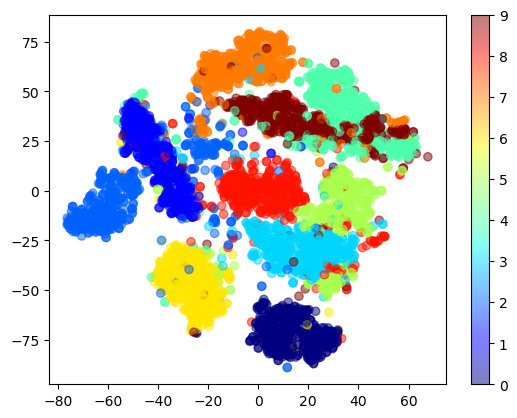

In [37]:
import matplotlib.pyplot as plt

plt.scatter(X_reduced_sne[:, 0], X_reduced_sne[:,1], c=y_train_sne.astype(np.int8), cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

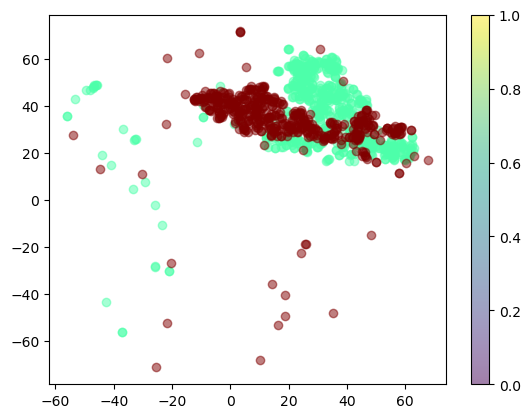

In [54]:
# checking for digits 9 and 4

cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced_sne[y_train_sne == digit, 0], X_reduced_sne[y_train_sne == digit, 1], c=[cmap(float(digit) / 9)], alpha=0.5)
plt.colorbar()
plt.show()

In [56]:
indx = (y_train_sne == '4') | (y_train_sne=='9')
X_sub_4_9 = X_train_sne[indx]
y_sub_4_9 = y_train_sne[indx]

tsne_subset = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_sub_4_9)

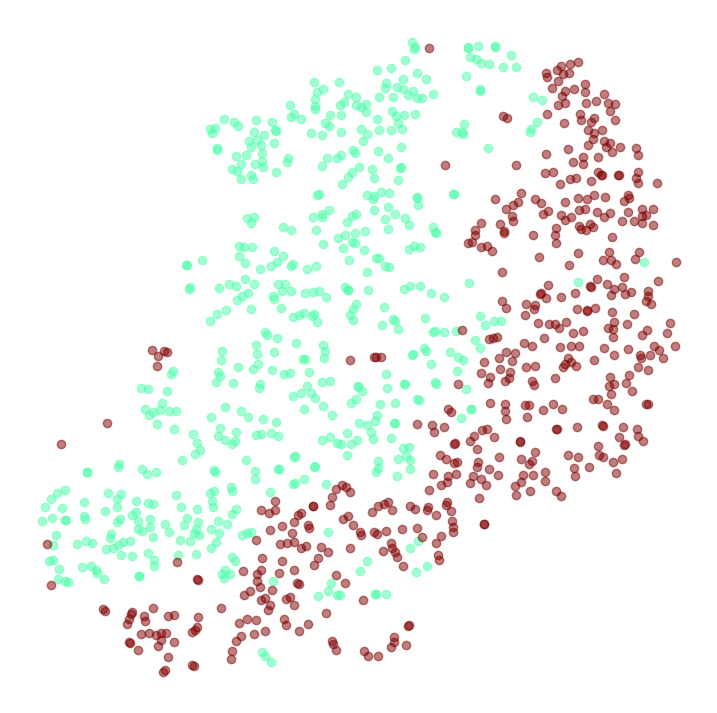

In [58]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_sub_4_9 == digit, 0],
                X_subset_reduced[y_sub_4_9 == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()